In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
drive_path="/content/drive/Mydrive"


Mounted at /content/drive/


In [ ]:
import os

folder_path = "/content/drive/MyDrive/images_750"
os.chdir(folder_path)

file_list = os.listdir()  # Get the list of files in the folder
print(len(file_list))

image_files = [file_name for file_name in file_list if file_name.endswith((".jpg", ".png", ".jpeg"))]
image_files.sort()  
print(len(image_files))
new_name = 0
for file_name in image_files:
    new_file_name = str(new_name) + file_name[file_name.rfind('.'):]
    os.rename(file_name, new_file_name)
    new_name += 1

print(len(image_files))

250
250
250


In [ ]:
import os

folder_path = "/content/drive/MyDrive/masks_750"
os.chdir(folder_path)

file_list = os.listdir()  # Get the list of files in the folder
print(len(file_list))

mask_files = [file_name for file_name in file_list if file_name.endswith((".jpg", ".png", ".jpeg"))]
mask_files.sort()  
print(len(mask_files))
new_name = 0
for file_name in mask_files:
    new_file_name = str(new_name) + file_name[file_name.rfind('.'):]
    os.rename(file_name, new_file_name)
    new_name += 1

print(len(mask_files))

250
250
250


In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import glob


class dance_data(Dataset):
  def __init__(self,image_dir,mask_dir,transform):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    '''self.image =image_path#!unzip /content/images_all.zip
    self.mask=mask_path#!unzip /content/masks_all.zip'''
    self.transform=transform
    
  
  def __len__(self):
    return len(self.image_dir)

  def __getitem__(self, index):
    image = np.array(Image.open("/content/drive/MyDrive/images_750/"+str(index)+".png").convert("RGB"))
    mask = np.array(Image.open("/content/drive/MyDrive/masks_750/"+str(index)+".png").convert("L"), dtype=np.float32)
    
    
    
    mean = np.mean(image, axis=(0, 1))
    std = np.std(image, axis=(0, 1))
    
    # Normalized image
    image = (image - mean) / std


    mask[mask == 255.0] = 1.0
    if self.transform != None:

      augmentation=self.transform(image=image,mask=mask)
      image=augmentation['image']
      mask=augmentation['mask']

    return image,mask 

      

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # encoder part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # decoder part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
   
    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

 
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    if preds.shape == x.shape:
      print(x.shape)
      print(preds.shape)
      print("shape matches")

if __name__ == "__main__":
    test()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])
shape matches


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split





def train(num_epochs,loader, model, optimizer, loss_fn):
    
    loop = tqdm(loader)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        num_correct = 0
        num_pixels = 0
        total = 0
        for batch_idx, (data, targets) in enumerate(loop):
            targets = targets.float().unsqueeze(1)

            # forward
            predictions = model(data)
            loss = loss_fn(predictions, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update tqdm loop
            loop.set_postfix(loss=loss.item())
            total_loss += loss.item()
            
            preds = torch.sigmoid(predictions)
            preds = (preds > 0.5).float()
            num_correct += (preds == targets).sum()
            num_pixels += torch.numel(preds)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {num_correct/num_pixels*100:.2f}%")            



In [ ]:
def get_loaders(train_dir,train_maskdir,val_dir,val_maskdir,batch_size,train_transform,val_transform):
    train_ds = dance_data(image_dir=train_dir,mask_dir=train_maskdir,transform=train_transform)
        

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = dance_data(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            


    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")


'\ndef save_predictions_as_imgs(\n    loader, model, folder="saved_images/", device="cuda"\n):\n    model.eval()\n    for idx, (x, y) in enumerate(loader):\n        x = x.to(device=device)\n        with torch.no_grad():\n            preds = torch.sigmoid(model(x))\n            preds = (preds > 0.5).float()\n        torchvision.utils.save_image(\n            preds, f"{folder}/pred_{idx}.png"\n        )\n        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")\n\n    model.train()'

In [ ]:
from google.colab import files
from torchvision.transforms import ToPILImage

def save_predictions_as_imgs(loader, model, drive_folder_path):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        # Convert the tensor image to a PIL Image
        pred_img = ToPILImage()(preds.squeeze())

        # Save the PIL Image to the desired folder in Google Drive
        pred_img.save(f"{drive_folder_path}/pred_{idx}.png")

       


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split


# Hyperparameters etc.
LEARNING_RATE = 1e-4
BATCH_SIZE = 4
NUM_EPOCHS = 5
IMAGE_HEIGHT = 160 
IMAGE_WIDTH = 240 
LOAD_MODEL = False

images_all="/content/drive/MyDrive/images_750"
masks_all="/content/drive/MyDrive/masks_750"


train_images, val_images = train_test_split(images_all, test_size=0.2, random_state=42)
train_masks, val_masks = train_test_split(masks_all, test_size=0.2, random_state=42)

train_transform = A.Compose(
[
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
],
)

val_transforms = A.Compose(
[
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
],
)

model = UNET(in_channels=3, out_channels=1)
model.train()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(train_images,train_masks,val_images,val_masks,BATCH_SIZE,train_transform,val_transforms)

train(NUM_EPOCHS,train_loader, model, optimizer, loss_fn)

check_accuracy(val_loader, model)

save_predictions_as_imgs(val_loader, model, "/content/drive/MyDrive/pred")





100%|██████████| 7/7 [02:25<00:00, 20.81s/it, loss=0.617]


Epoch [1/5], Loss: 4.7616, Accuracy: 65.93%
Epoch [2/5], Loss: 3.9454, Accuracy: 83.08%
Epoch [3/5], Loss: 3.5890, Accuracy: 88.34%
Epoch [4/5], Loss: 3.2842, Accuracy: 91.54%
Epoch [5/5], Loss: 2.9933, Accuracy: 92.93%
Got 236370/268800 with acc 87.94
Dice score: 0.0


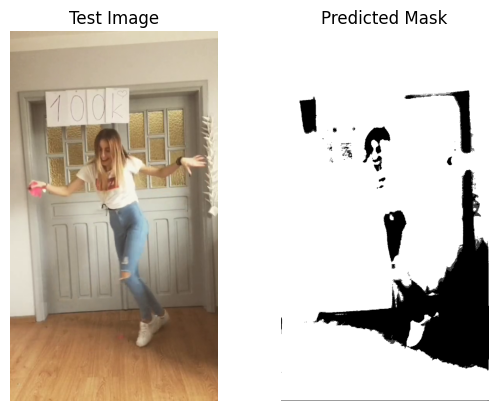

In [ ]:
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


test_image=Image.open("/content/drive/MyDrive/images_250/0.png")


model.eval()

# Convert the test image to a tensor
test_image_tensor = ToTensor()(test_image)

# Add a batch dimension to the test image tensor
test_image_tensor = torch.unsqueeze(test_image_tensor, dim=0)

# Generate the predicted mask
with torch.no_grad():
    predicted_mask = model(test_image_tensor)

# Apply a sigmoid function to obtain the probabilities
predicted_mask = torch.sigmoid(predicted_mask)

# Convert the predicted mask to a numpy array
predicted_mask = predicted_mask.detach().numpy()

# Select the mask for the first image in the batch 
predicted_mask = predicted_mask[0, 0]  

# Threshold 
predicted_mask_binary = (predicted_mask > 0.5).astype(int)

# Display the test image and the predicted mask
fig, axes = plt.subplots(1, 2)
axes[0].imshow(test_image)
axes[0].set_title('Test Image')
axes[0].axis('off')
axes[1].imshow(predicted_mask_binary, cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.show()
